თხოვნა იქნება, რომ თუ სურათები და ვიზუალიზაცია დაგხვდებათ, ისე გადახედოთ თავიდან მთლიან პროექტს და მსჯელობებს და მერე გაუშვათ თქვენთან. რახან დაკლასტერება სულ ერთნაირად არ ხდება, შესაძლოა იმ შემთხვევაში, თუ თქვენ გაუშვებთ მოცემულ კლასტერებს დაწერილი მსჯელობები აღარ შეესაბამებოდეს. უბრალოდ ეს რომ ავირიდოთ თავიდან. სამწუხაროდ ვცადე დაფიქსირება სულ ერთნაირად რომ ექნა მაგრამ ვერაფრით ვერ მოვახერხე.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

პირველ რიგში, ტესტ დატა-ს ვაერთიანებ თრეინ დატასთან, რადგან მიზანი უბრალოდ სეგმენტებად დაყოფაა და კაგლის ამოცანას არ ვაკეთებთ. შესაძლოა ტესტ დატა შეიცავდეს ისეთ ინფორმაციას, რაც დაგვეხმარება უკეთ დავაკლასტეროთ

In [29]:
data = pd.read_csv("Train.csv")
tst = pd.read_csv("Test.csv")
data.merge(tst)
data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


თავიდანვე ჩანს, რომ ID არის ზედმეტი მონაცემი, ამიტომ ამოვაგდებ მონაცემებიდან

In [30]:
data = data.drop(columns='ID')

In [31]:
data.isnull().sum()

Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [32]:
from scipy import stats
mode = stats.mode(data['Family_Size'])
md = mode[0][0]
values = {'Family_Size': md}
data.fillna(value=values, inplace = True)
mode = stats.mode(data['Work_Experience'])
md = mode[0][0]
values = {'Work_Experience': md}
data.fillna(value=values, inplace = True)
data.head(5)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,Female,Yes,38,Yes,Engineer,1.0,Average,3.0,Cat_4,A
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,Female,Yes,40,Yes,Entertainment,1.0,High,6.0,Cat_6,A


In [33]:
nulls = ['Ever_Married','Profession', 'Graduated', 'Var_1']
cat_data = data.select_dtypes(include=['object']).copy()
for feature in nulls:
    cat_data = cat_data.fillna(cat_data[feature].value_counts().index[0])

In [34]:
cat_data.isnull().sum()

Gender            0
Ever_Married      0
Graduated         0
Profession        0
Spending_Score    0
Var_1             0
Segmentation      0
dtype: int64

In [35]:
cats = cat_data.columns.values
cats

array(['Gender', 'Ever_Married', 'Graduated', 'Profession',
       'Spending_Score', 'Var_1', 'Segmentation'], dtype=object)

In [36]:
categoricals = cat_data.columns.values
for categorical in categoricals:
    data = data.drop(columns=categorical)

In [37]:
for categorical in categoricals:
    data.insert(1, categorical, cat_data[categorical], True)

In [38]:
df = data.copy()
data.head(5)

,Age,Segmentation,Var_1,Spending_Score,Profession,Graduated,Ever_Married,Gender,Work_Experience,Family_Size
0,22,D,Cat_4,Low,Healthcare,No,No,Male,1.0,4.0
1,38,A,Cat_4,Average,Engineer,Yes,Yes,Female,1.0,3.0
2,67,B,Cat_6,Low,Engineer,Yes,Yes,Female,1.0,1.0
3,67,B,Cat_6,High,Lawyer,Yes,Yes,Male,0.0,2.0
4,40,A,Cat_6,High,Entertainment,Yes,Yes,Female,1.0,6.0


ერთი პრობლემა ასე თუ ისე გადაიჭრა და ახლა აღარ გვაქვს გამოტოვებული ველები. ეს საშუალებას მოგვცემს გამოვიყენოთ ჩვენთვის სასურველი ალგორითმები და დავამშავოთ მონაცემები სურვილისამებრ. 
სანამ მეორე ეტაპს დავიწყებ და მოცემულ კატეგორიულ ცვლადებს რიცხვებით ჩავანაცვლებ, მინდა "უკეთ გავიცნო" მონაცემები, მათი განაწილებები, ტიპები, რაოდენობები და ა.შ. ახლა ვაკეთებ ამას, იმიტომ რომ უფრო ნათელი იყოს და გადაქცეულმა კატეგორიულმა ცვლადებმა რამე დაბნეულობა არ გამოიწვიონ

In [39]:
def draw_bar_plot(feature, cat_data):
    feature_count = cat_data[feature].value_counts()
    guys = feature_count.index
    vals = feature_count.values
    plt.barh(guys,vals)
    plt.title(feature)
    plt.tight_layout()
    plt.show()
    
def draw_pie(feature, cat_data):
    feature_count = cat_data[feature].value_counts()
    guys = feature_count.index
    vals = feature_count.values
    plt.pie(vals, labels=guys, wedgeprops = {'edgecolor' : 'black'}, shadow=True, startangle=90)
    plt.title(feature)
    plt.tight_layout()
    plt.show()

In [40]:
%matplotlib inline

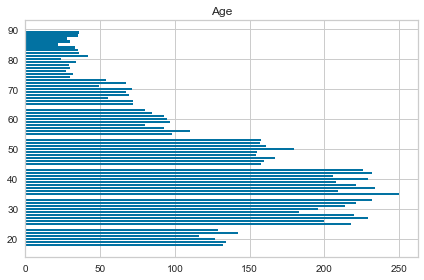

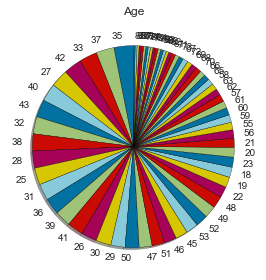

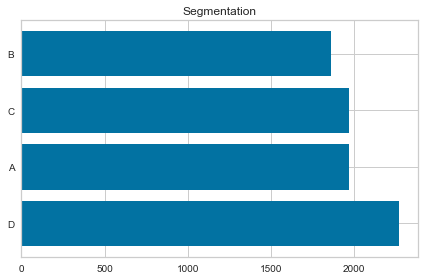

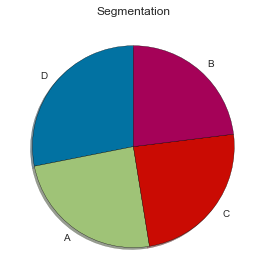

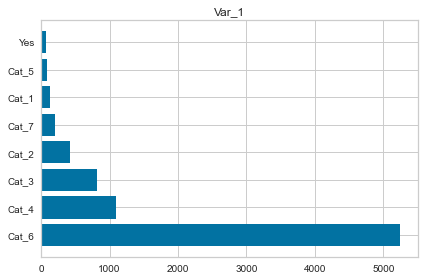

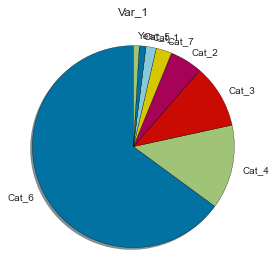

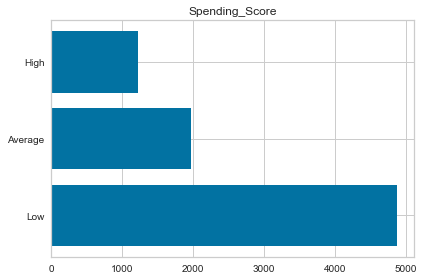

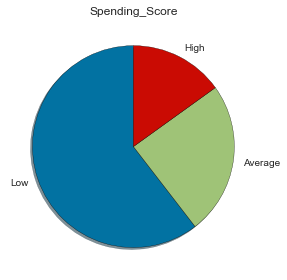

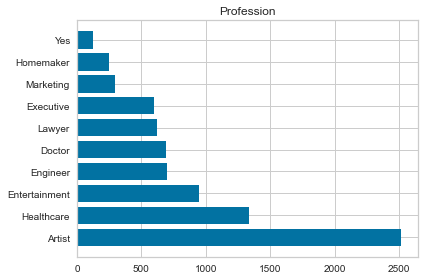

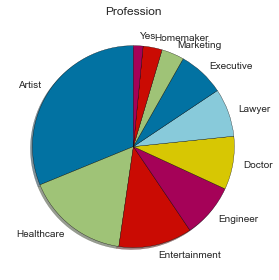

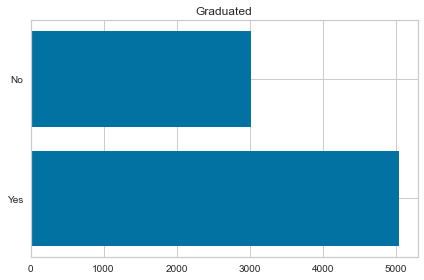

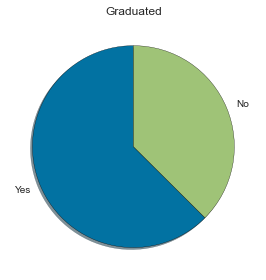

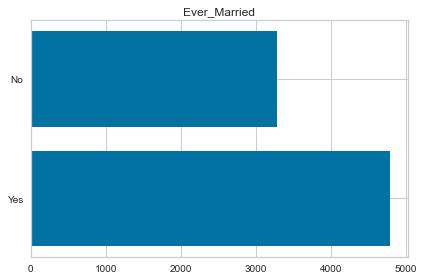

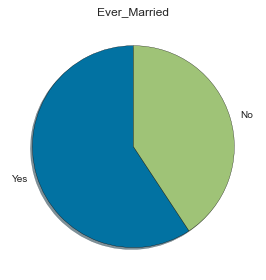

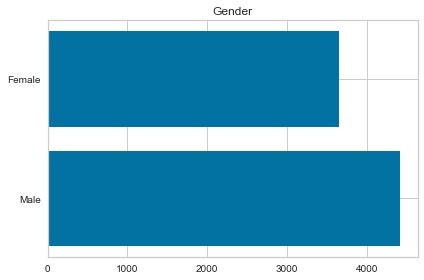

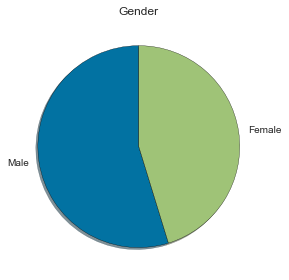

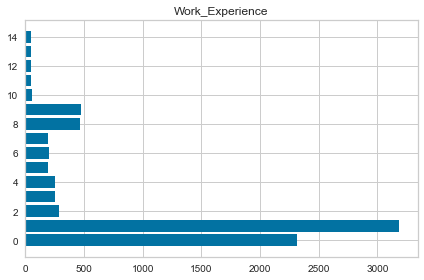

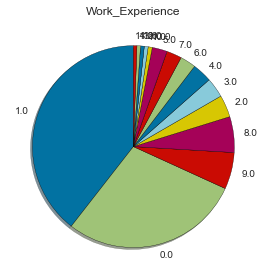

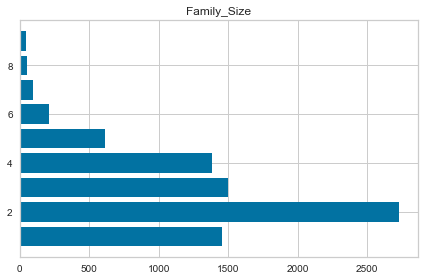

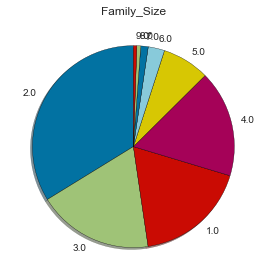

In [41]:
features = data.columns.values
for feature in features:
    draw_bar_plot(feature, data)
    draw_pie(feature, data)

იმისათვის, რომ კატეგორიული ცვლადები გადავაქციო რიცხვებად, ვიყენებ LabelEncoder-ს.

In [42]:
from sklearn.preprocessing import LabelEncoder
categoricals = data.select_dtypes(include=['object']).columns.values
label_encoder = LabelEncoder()
for categorical in categoricals:
    data[categorical] = label_encoder.fit_transform(data[categorical])

In [43]:
data.head(5)

,Age,Segmentation,Var_1,Spending_Score,Profession,Graduated,Ever_Married,Gender,Work_Experience,Family_Size
0,22,3,3,2,5,0,0,1,1.0,4.0
1,38,0,3,0,2,1,1,0,1.0,3.0
2,67,1,5,2,2,1,1,0,1.0,1.0
3,67,1,5,1,7,1,1,1,0.0,2.0
4,40,0,5,1,3,1,1,0,1.0,6.0


როცა დავალებებს გვაძლევენ, ძირითადად ისინი ისეა შერჩეული, რომ ზუსტად ერგება ნასწავლ მასალას. ამ შემთხვევაშიც, მოცემული გვაქვს მონაცემები რომლებიც დიდი ალბათობით კარგად დაიყოფა, მაგრამ ყოველთვის მეფიქრება რა სიტუაციაა რეალურ სამუშაოზე ამ მხრივ. ამაზე ვფიქრობ იმიტომ, რომ მგონია, შეუძლებელია ყველა data დაკლასტერდეს კარგად და გამოკვეთილად.
ამიტომ დავიწყე მეთოდების ძებნა, რომელიც შეაფასებდა რამდენად შესაძლებელია მონაცემების დაკლასტერება და წავაწყდი "Hopkins Statistics"-ს, რომელიც მსგავსი შეფასებებისთვის საკმაოდ კარგი მეთოდი აღმოჩნდა. შესაძლოა მან მთლად კარგი მეთოდი არ მოგვცეს, რადგან კატეგორიული მონაცემების რაოდენობა მკვეთრად მეტია ჩვეულებრივზე, მაგრამ ცდად მაინც ღირს.

მოცემული მეთოდის მუშაობის პრინციპი ასეთია: თუ დააბრუნა 1 თან ახლოს მყოფი რიცხვი, ეს ნიშნავს რომ კლასტერიზაცია შესაძლოა მოხდეს გადაფარვების გარეშე, ძალიან კარგად და აკურატულად. ხოლო 0.5 ნიშნავს რომ საკმაოდ ცუდი მონაცემები გვაქვს დასაკლასტერებლად.

In [201]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) # heuristic 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [202]:
hopkins(data)

0.7272221816628942

მოცემული ალგორითმი რანდომზე ირჩევს წერტილების ნაწილს. ეს განაპირობებს იმას, რომ დაბრუნებული ქულის მნიშვნელობა იცვლება, მაგრამ ჩემი დაკვირვებით ის მერყეობს [0.72, 0.78] შუალედში. რაც ცხადია, ცუდი შედეგი არ არის

ახლა კი დროა დავიწყოთ მონაცემების დამუშავება და დაკლასტერება. ჩვენ ვისწავლეთ k-means ალგორითმი, რომელიც საკმაოდ კარგად მუშაობს და გამოყოფს მონაცემებს ერთმანეთს, მაგრამ იმ შემთხვევაში თუ არ გვაქვს კატეორიული ცვლადები. ეს უკანასკნელი საქმეს უფუჭებს k-mean-ს. რადგან ალგორითმი მოქმედებს უშუალოდ წერტილებს შორის მანძილების გაზომვით, ცხადია არალოგიკურია წერტილებად ჩავთვალოთ რიცხვებში გადაქცეული კატეგორიული ცვლადებიც. ამან შესაძლოა არასწორ დასკვნამდე მიგვიყვანოს.
ამის გათვალისწინებით, გადავწყვიტე მის მაგივრად გამომეყენებინა k-prototypes რომელიც არის k-mode-სა და k-mean ის ერთგვარი გაერთიანება. გამოტოვებული ადგილების შევსება სწორედ ამიტომ გადავწყვიტე მოდებით. თავიდან ისიც ვიფიქრე, რომ მედიანებით შევავსებდი რათა საშუალოდ ყოფილიყო განაწილებული, მაგრამ საბოლოოდ მაინც მოდებით შევსება გადავწყვიტე.

k-prototype-ს გამოსაყენებლად როგორც ვნახე საჭიროა მონაცემების დასკალირება, მიუხედავად იმისა, რომ 0-10 შუალედში იმერყეონ მაქსიმუმ

In [44]:
from sklearn import preprocessing
data_scaled = preprocessing.scale(data)

ახლა კი მოცემული პობლემის ერთ-ერთ მთავარ ეტაპზე ვართ: ავარჩიოთ კლასტერების რაოდენობა სწორად. ამისათვის გამოვიყენებ Elbow მეთოდს და ვნახავ დიაგრამაზერა სიტუაციაა 1 დან 10 ის ჩათვლით განვიხილავ K-ს თითოეულ ვარიანტს. ამას გავაკეთებ KElbowVisualizer-ის საშუალებით, რომელსაც უნდა გადავცეთ შესაბამისი მოდელი და K-ს რაოდენობა. მოდელში თითოეული K სთვის ვაკეთებ 5 იტერაციას, რადგან წერტილების აღება აქაც რანდომად ხდება და შესაძლოა მხოლოდ ერთმა ან ორმა იტერაციამ შეცდომა მოგვცეს. თავიდან ვუთითებდი 20-ს და ნელნელა ჩამოვედი 5 ზე,რადგან KPrototype-ს საკმაოდ დიდი დრო ჭირდება.იმპლემენტაციაში ჩავიხედე და ამის მიზეზი მგონი ის არის რომ უბრალოდ for ებით წერია და არა ვექტორებზე მოქმედებებით.

(P.S Elbow-ს მეთოდი საკმაოდ დიდიხანი მუშაობს, რა აღარ ვცადე მაგრამ ვერაფრით გამოვუსწორე დროის ხანგრძლიბა, როცა K-mean მა ძალიან სწრაფად იმუშავა ექსპერიმენტების ტარების დროს, თუ ვიზუალი ჩანს, კარგი იქნება თუ მის გატესტვას ბოლოსთვის მოიტოვებთ)

In [45]:
%matplotlib inline

In [46]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from kmodes.kprototypes import KPrototypes
import matplotlib as mpl 

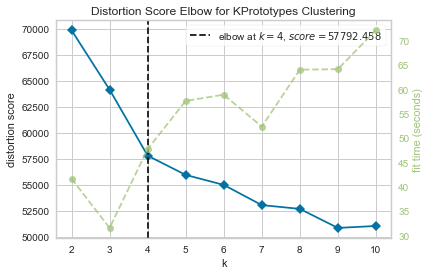

In [205]:
model = KPrototypes(n_init=5)
visualizer = KElbowVisualizer(model, k=10)
visualizer.fit(data_scaled,categorical=[1,2,3,4,5,6,7,8])    # Fit the data to the visualizer
visualizer.poof()  

აჩვენებს, რომ უნდა ავიღო 4 კლასტერი. იმის შესამოწმებლად, რამდენად კარგად დაიყოფა 4 ნაწილად, ვიყენებ silhouette score-ს, რომელიც [-1,1] შუალედში რიცხვს აბრუნებს და რაცუფრო დიდია შედეგი, მით უფრო კარგად შეილება დაყოფა.

In [47]:
from sklearn.metrics import silhouette_samples, silhouette_score

kp = KPrototypes(n_init=10, n_clusters = 4)
y = kp.fit_predict(data, categorical=[1,2,3,4,5,6,7,8])
score = silhouette_score(data, y)
print(score)

0.3899382726403826


ვვარაუდობდი რომ ის არ მომცემდა კარგ შედეგს, და დაახლოებით ასეც მოხდა. [0.35, 0.45] ნამდვილად არ არის დიდად სახარბიელო, მაგრამ ეს იმის ბრალი იქნება, რომ ბევრი კატეგორიული ცვლადი გვაქვს. ისინი უბრალოდ ყველაფერს აფუჭებენ :(

ამის პარალელურად, y-ში უკვე შენახულია შესაბამისი მონაცემის შესაბაისი კლასტერი. ახლა არის ის მომენტი, როცა უნდა მოვახდინოთ ვიზუალიზაცია და ვნახოთ რამდენად კარგად დაკლასტერდა. შემდეგ კი მინდა განვიხილო თითოეულ კლასტერში ვინ მოხვდა და ვინ არა. 
რადგანაც კატეგორიული ცვლადები საკმაოდ ბევრი გვქონდა, ვიზუალიზაციისთვის PCA მაგივრად გამოვიყენე FAMD, რადგან მას შეუძლია MCA-ს მსგავსად, კარგად გაუმკლავდეს კატეგორიულ ცვლადებს. ჯერ დავხატავ 2 განზომილებაშ, შემდეგ კი სამ განზომილებიანს. იტერაციების რაოდენობად ვატან 3-ს რადგან 3 ის შემდეგ დაახლოებით ერთი და იგივე შედეგს ვგებულობ.

In [48]:
data['Clusters'] = y
import prince
for col in categoricals:
    data[col] = data[col].astype(str)
famd = prince.FAMD(
n_components=2,
n_iter=3,
copy=True,
check_input=True,
random_state=55)
famd = famd.fit(data.drop('Clusters', axis='columns'))
coordinates = famd.row_coordinates(data)

In [49]:
%matplotlib inline

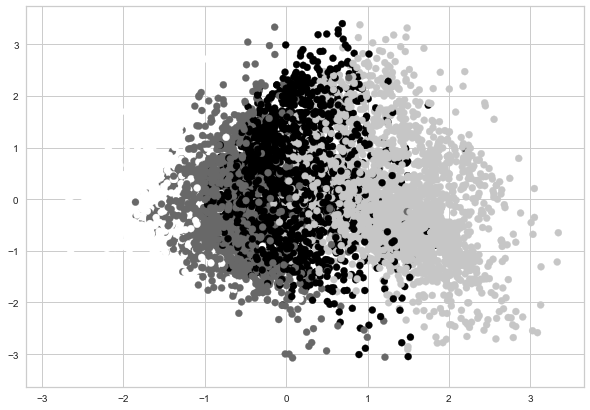

In [50]:
fig = plt.figure(figsize=(10,7))
plt.scatter(coordinates[0], coordinates[1], c=y.astype(float))
plt.show()

In [51]:
for col in categoricals:
    data[col] = data[col].astype(str)
famd = prince.FAMD(
n_components=3,
n_iter=3,
copy=True,
check_input=True,
random_state=55)
famd = famd.fit(data.drop('Clusters', axis='columns'))
coordinates = famd.row_coordinates(data)

In [52]:
%matplotlib inline

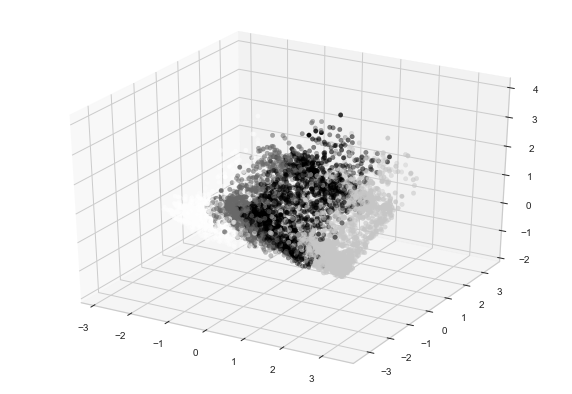

In [53]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(coordinates[0], coordinates[1], coordinates[2],c=y.astype(float))
plt.show()

როგორც ორგანზომილებიანში, სამიანშიც საკმაოდ კარგად გამოჩნდა გამოყოფილი კლასტერები. მგონი საკმაოდ კარგად გამოყო ისინი ერთმანეთისგან. ყოველ შემთხვევაში, ასე ჩანს. უფრო ღრმად განხილვისთვის კი საჭიროა დაახლოებით ვივარაუდოდ რა ტიპის ადამიანები იქნებიან თითოეულ კლასტერში. ამის დასადგენად ვეცდები ვიზუალიზაცია და გრაფიკები დავიხმარო.

In [54]:
df['Clusters'] = y
clusters = [df[df.Clusters == i] for i in range(0,4)]

In [72]:
def draw_cluster_features(clusters,cluster_number, features):
    for feature in features:
        draw_bar_plot(feature, clusters[cluster_number])
        draw_pie(feature, clusters[cluster_number])

df დატა-ში მონაცემები გადავაკოპირე რადგან როცა დაკლასტერებული მონაცემების ანალიზს გავაკეთებდი რიცხვების მაგივრად კვლავ შემძლებოდა შესაბამისი ცვლადის სახელის გამოყენება. ახლა გავაკეთებ თითოეული კლასტერის ვიზუალიზაციას და დავაკვირდები რა ტიპის მონაცემები არის მასში.

                                            ბედნიერი მოხუცები
პირველ კლასტერში გაერთიანებული არიან ადამინაები, რომლებიც გადაცილებულები არიან 65 წელს. მათ დიდი რაოდენობა არის ადვოკატი, როცა მთლიან დატაში ადვოკატების რაოდენობა ნამდვილად არ არის დიდი და არტისტების პროცენტული წილი ბევრად დიდია. აღსანიშნავია, რომ ასევე ძალიან დიდი ნაწილი არის დაოჯახებული. ეს ერთი მხრივ ლოგიკურიცაა ასაკის გათვალისწინებით. ოჯახის წევრთა რაოდენობა კი ძალიან იშვიათად ცდება 3-ს. უმეტესობას მიღებული აქვს განათლება და საკმაოდ ბევრ ფულსაც ხარჯავენ. მათზეა ზედგამოჭრილი ის ანდაზა სკოლაში ყველას რომ ამოგვადინეს ყელში: "სწავლის ძირი მწარე არის კენწეროში გატკბილდებისო...". ასევე აღსანშნავია, რომ უმეტესობას 1 ან 2 სამსახური ჰქონდათ და არ იცვლიდნენ მას. 

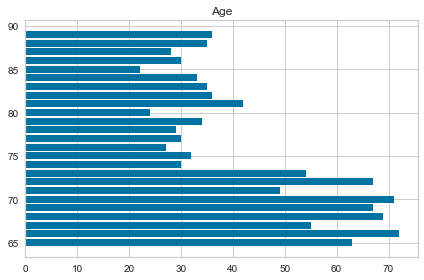

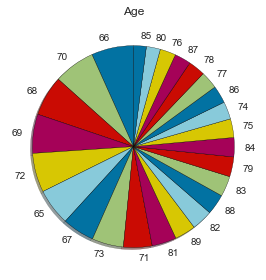

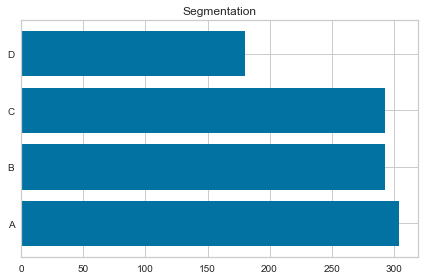

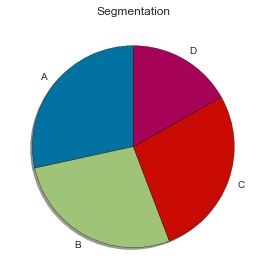

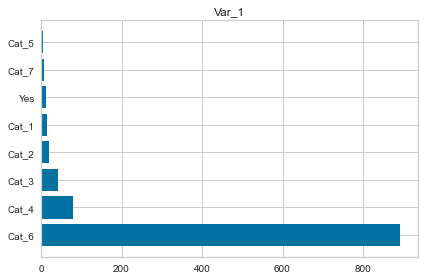

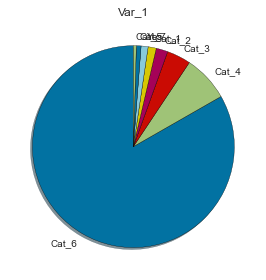

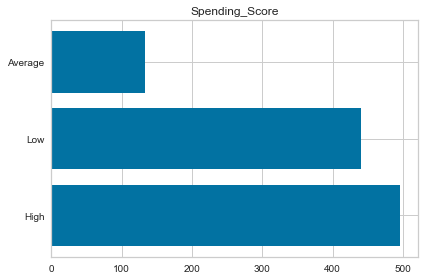

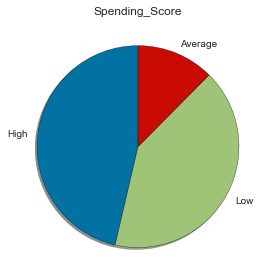

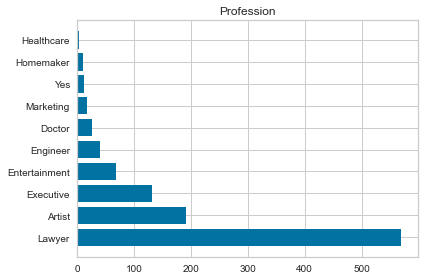

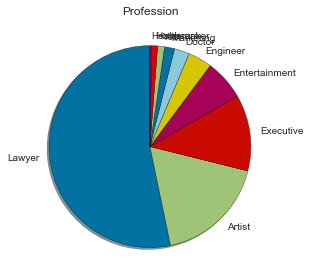

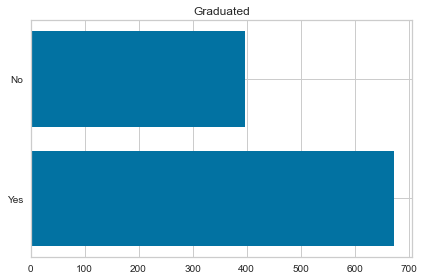

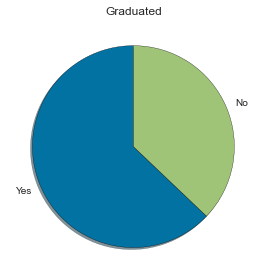

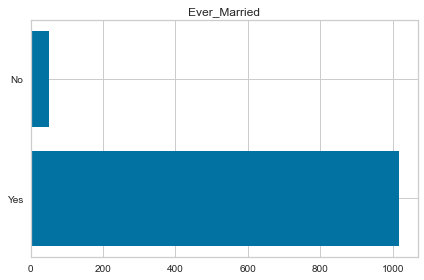

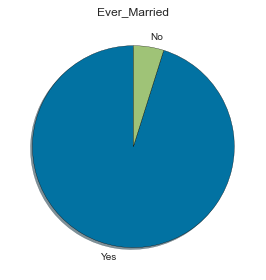

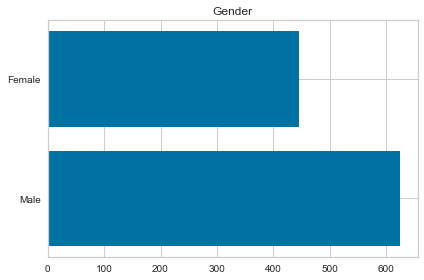

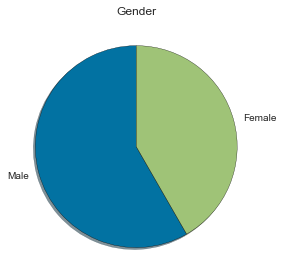

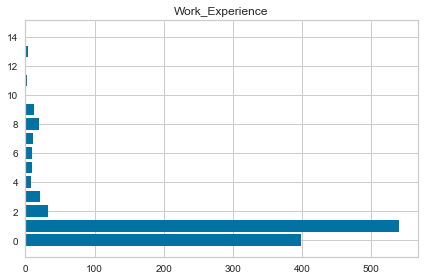

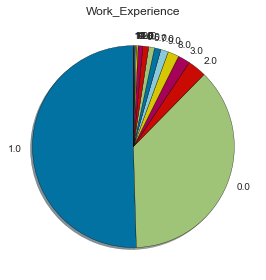

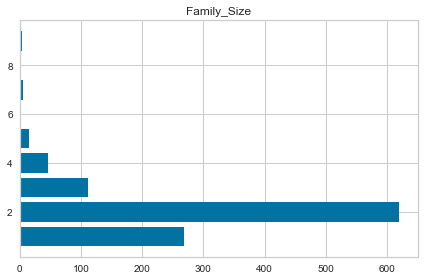

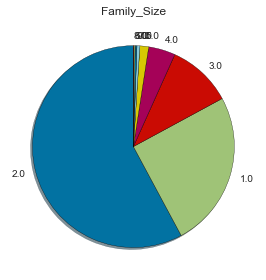

In [73]:
draw_cluster_features(clusters, 0, features)

                                       უდარდელი ახალგაზრდები
ეს კატეგორია რადიკალურად განსხვავებულია წინასგან. აქ გვყავს ძირითადად ახალგაზრდა ადამიანები. მათი დიდი ნაწილი არ არის დაოჯახებული და არ აქვს მიღებული განათლება. მათი უმეტესობა healthcare ს აქცევს ყურადღებას და საინტერესოა, რომ არცერთი მათგანი არ არის ადვოკატი.
იმის გათვალისწინებით რომ ძალიან ცოტას ხარჯავენ და სტაბილური სამსახური არ აქვთ, სრულიად ლოგიკურია რომ მათი ოჯახის წევრების რაოდენობა თანაბრადაა დაახლოებით გადანაწილებული [2,5] შუალედში. ვივარაუდოთ შეიძლება რომ მშობლებთან ცხოვრობენ ან მათ ხარჯზე :დ 
საინტერესო რაღაც ხდება სამუშაოსთან დაკავშირებით. მიუხედავად იმისა, რომ უმეტესობას არ უმუშავია, მათ ბევრად დიდ პროცენტულ წილს აქვს რამდენიმენაირი სამუშაო გამოცდილება ვიდრე მოხუცებს. სიმართლე რომ ვთქვათ, ვფიქრობდი რომ ასაკიანებს მეტი ექნებოდათ, მაგრამ დრო როგორც ჩანს დრო იცვლება ან ორ სხვადასხვა ფენასთან გვაქვს საქმე.

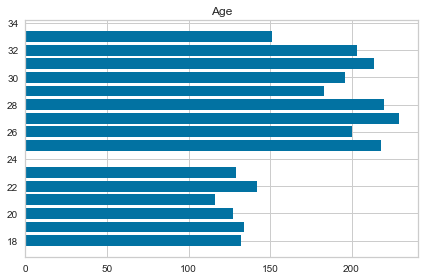

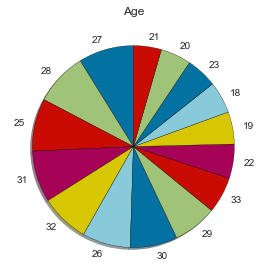

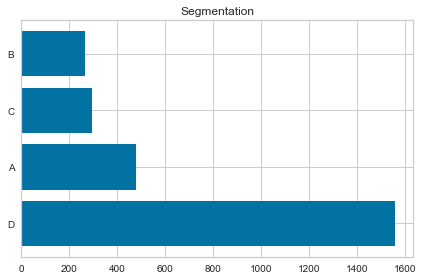

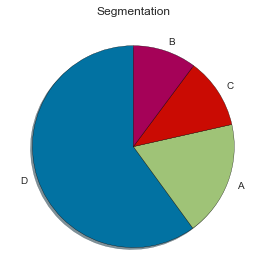

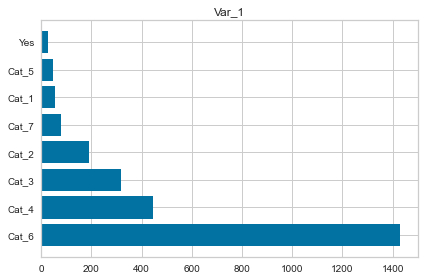

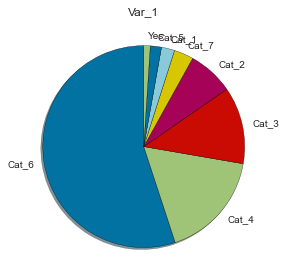

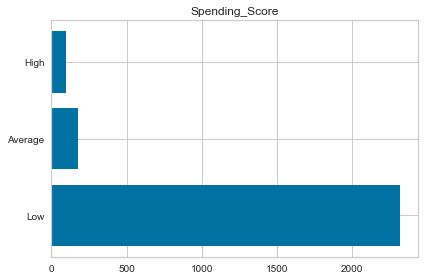

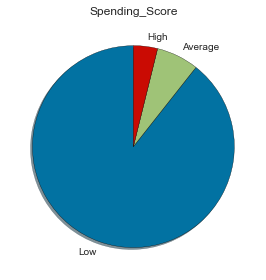

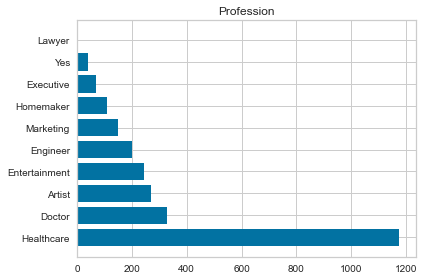

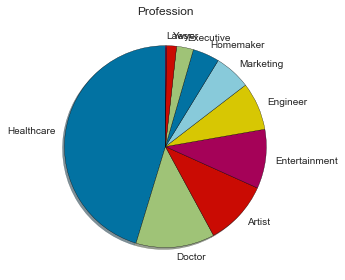

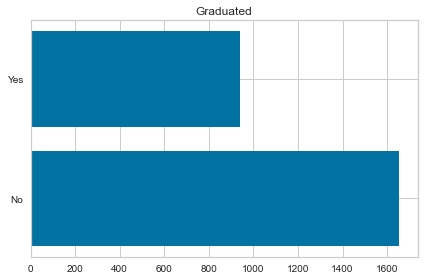

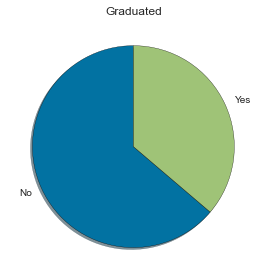

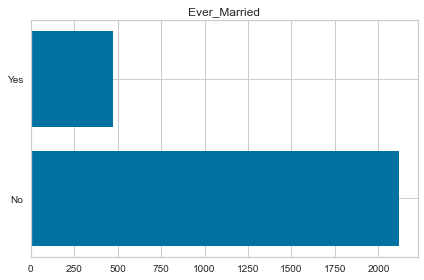

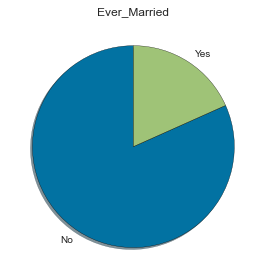

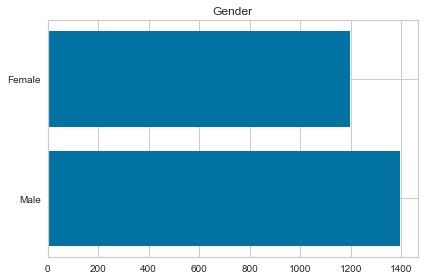

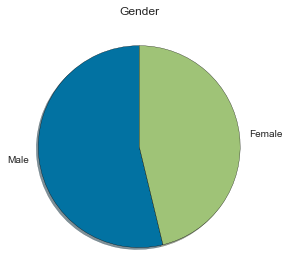

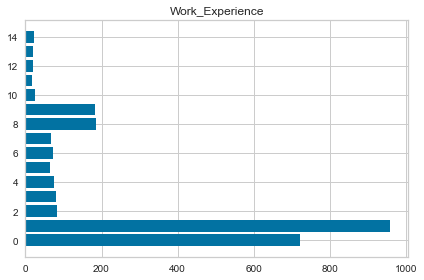

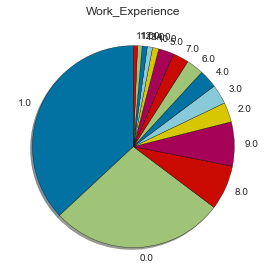

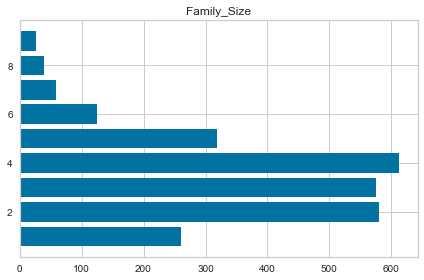

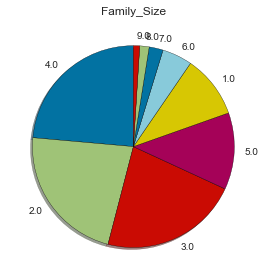

In [75]:
draw_cluster_features(clusters, 1, features)

                                        Regular People
ამ კლასტერში მყოფ ადამიანებს არ შეგვიძლია ვუწოდოთ მოხუცები მაგრამ ისინი არც ახალგაზრდები არ არიან, რადგან ასაკი 47-48 წლიდან იწყება. შეიძლება იყოს მოლოდინი, რომ მათაც ბევრი ფული ექნებათ, მაგრამ ეს ასე არ არის. როგორც გამოჩნდა, საშუალოდ მხარჯველები არიან და უმეტესობა მსახიობია. შეგვიძლია თამამად ვთქვათ, რომ ეს არის საშუალო ფენა. ბევრი არის ისეთი ვინც ცოტას ხარჯავს, მაგრამ მფლანგველებიც ბლომად გამოერვიან ხოლმე. ოჯახის წევრების რაოდენობა [2,4] შუალედში დაახლოებით თანაბრადაა განაწილებული. იმის გათვალისწინებით, რომ უმეტესობა დაოჯახებულია, ესეც ლოგიკურია, რადგან ეს არის სწორედ იმ ასაკის პერიოდი როცა ოჯახის უმცროსი წევრები (შვილები) ემზადებიან ცალკე საცხოვრებლად.

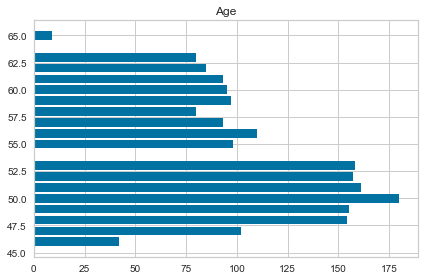

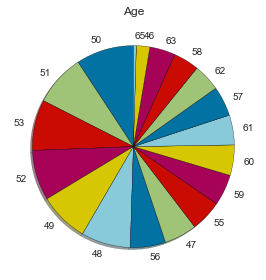

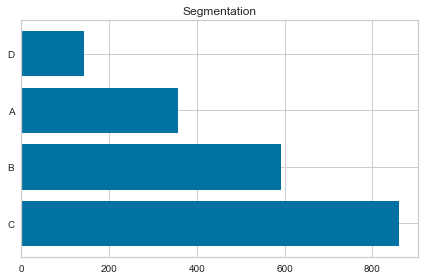

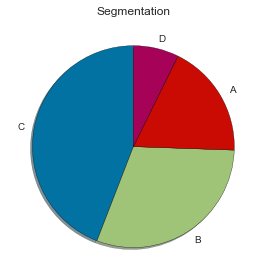

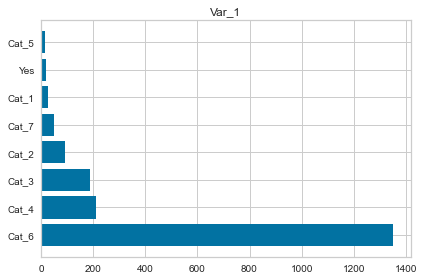

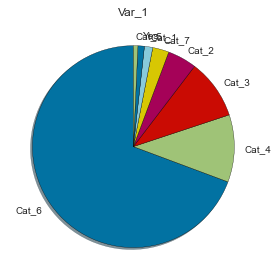

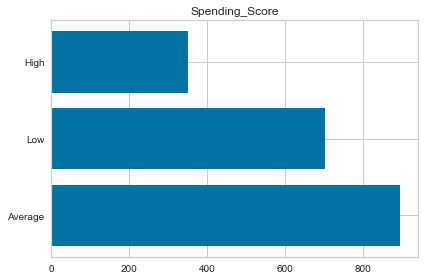

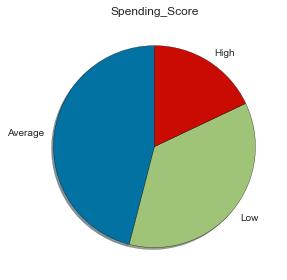

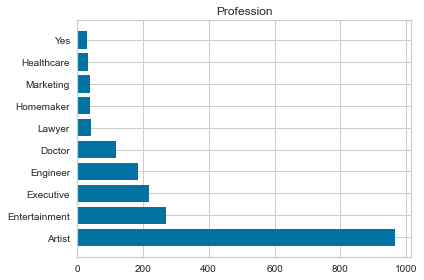

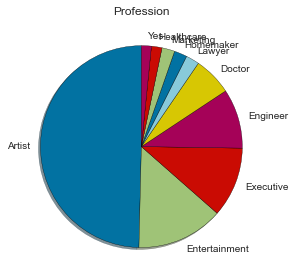

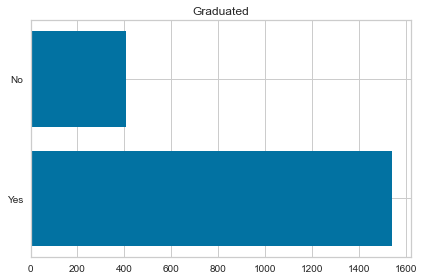

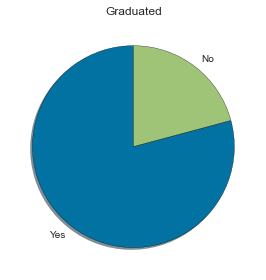

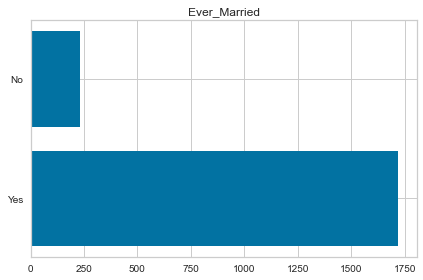

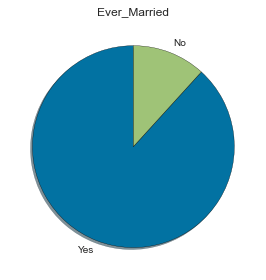

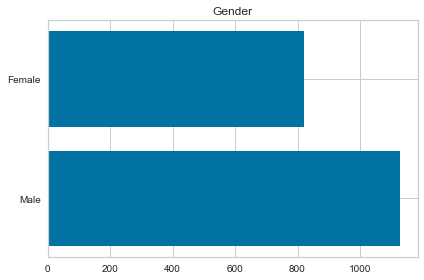

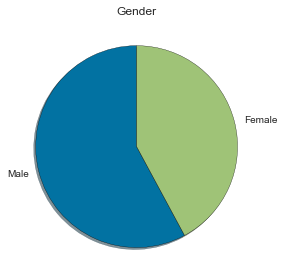

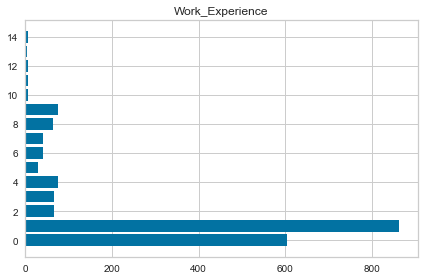

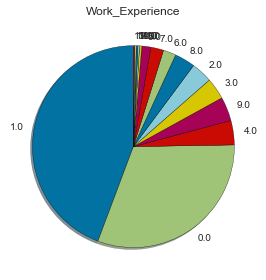

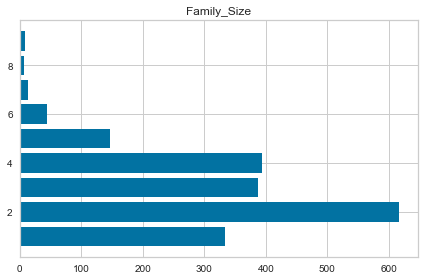

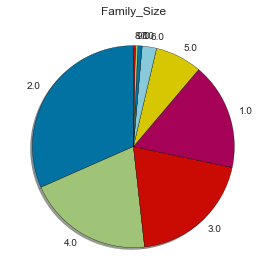

In [59]:
draw_cluster_features(clusters, 2, features)

                                          შერეული საზოგადოება
ამ კალსტერში მართლაც რომ შერეული საზოგადოება გვყავს. ამაში ვგულისხმობ იმას, რომ ნაწილი წარმატებულია და დახარჯვით ბევრს ხარჯავს, მაგრამ უმეტესობა მაინც იმით გმაოირჩევა, რომ ცოტა ფულს ხარჯავენ. არ დაგვავიწყდეს, რომ სწორედ აქ აქვთ ადამიანებს ის ასაკი, სადაც ზოგადად კარიერის პიკში არიან ხოლმე. სიმართლე რომ ვთქვა, ამ ასაკში მეგონა თუ იქნებოდა ყველაზე დიდი რეითი ფულის დახარჯვის. რადგან გარკვეულწილად არის პერიოდი, როცა ადამინი თავის კარიერაზეა კონცენტრირებული და არ აწუხებს სხვა რამეზე ფიქრი. მაგრამ მსახიობობა არ არის ისეთი სფერო სადაც თავდაუზოგავი შრომა აუცილებლად დაფასდება, ხოლო იმის გათვალისწინებით, რომ აქაც მსახიობები ჭარბობენ, ასე თუ ისე ლოგიკური შედეგია. სხვა ახსნის მოძებნა მიჭირს. 
ჩემი ყურადღება მიიქცია ფაქტმა, რომ გამოკვეთილად ჩანს დიაგრამებზე [8-10] სამუშაო გამოცდილება. ვერ ვხსნი რატომ არ არის ახლოს მასთან 5,6,7 ან სხვა რაოდენობები და რატომაა გამოყოფილი ეს სამეული. 
წინა კლასტერშიც უმეტესად მსახიობები გვხვდებოდნენ მაგრამ მოგნია, მათ შედარებით კარგი შემოსავალი ქონდათ. ასაკი და ეს არის ძირითადი განსხვავება მათ შორის. შეგვეძლო მათთვის დაგვერქმია "ჩამოყალიბებული და მოუმწიფებელი" მსახიობები.

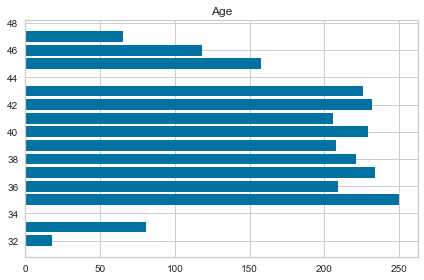

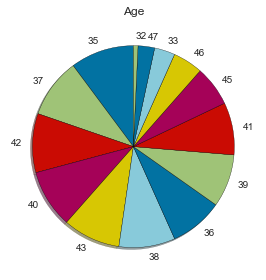

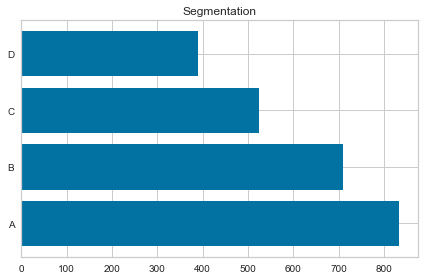

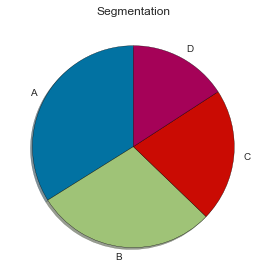

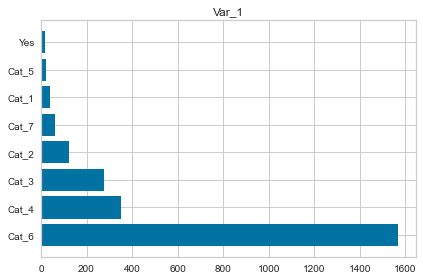

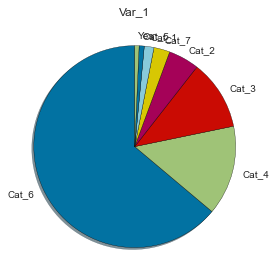

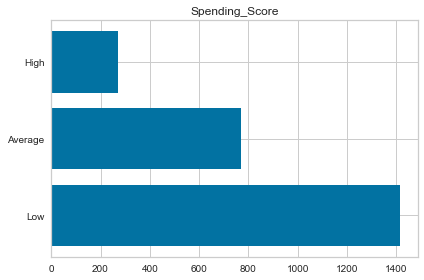

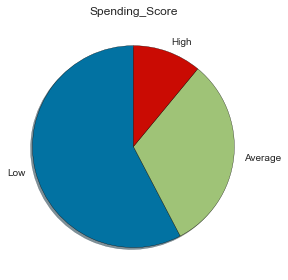

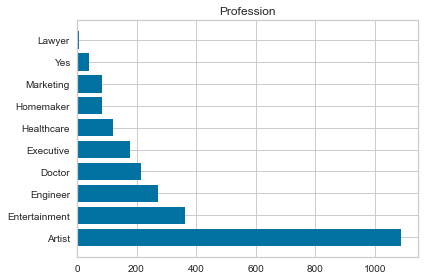

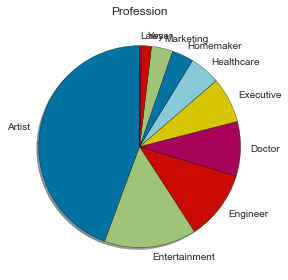

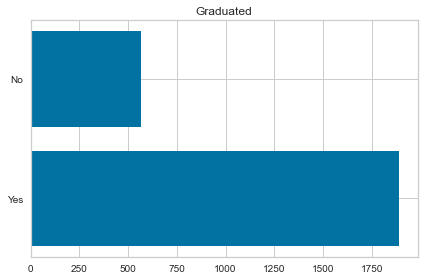

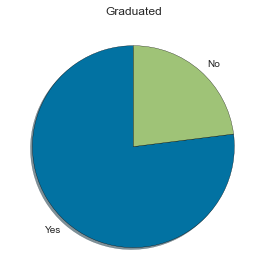

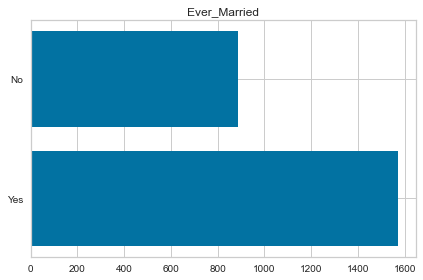

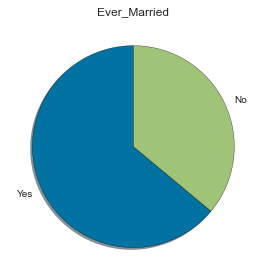

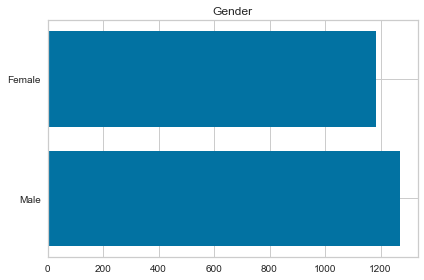

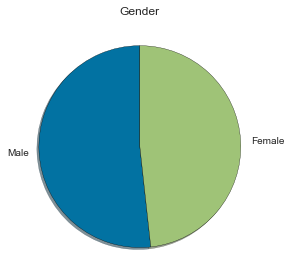

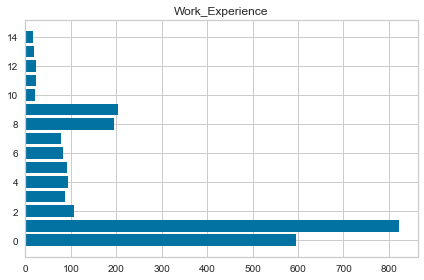

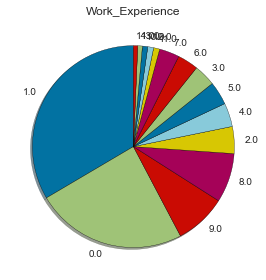

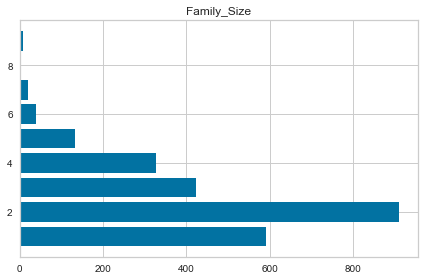

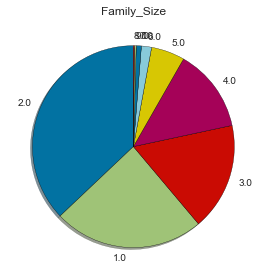

In [60]:
draw_cluster_features(clusters, 3, features)

საბოლოო ჯამში, მგონია, რომ საკმაოდ კარგად დაკლასტერდა მონაცემები. ოთხივე სეგმენტი სხხვადასხვა ტიპის ადამიანებს შეიცავს. სწორედ ეს იყო ჩვენი მიზანი. მაგრამ ამ დიაგრამების დახატვის დროს გამოჩნდა რამდენიმე დეტალი, მაგალითად ის, რომ ფიჩერი Var_1 საერთოდ არ იყო საჭირო, რადგან ის სრულიად თანაბრად იყო განაწილებული თითოეულ კლასტერში. ასევე არ მგონია, მნიშვნელობა ქონდეს სქესს. ვიფიქრე, ეს "პროტოტიპად" გამომეყენებინა და თავიდან დამეკლასტერებინა და ჩამეტარებია კვლევა უკვე დარჩენილ მონაცემებზე მაგრამ მგონი ძალიან გაიწელება მოცემული დავალება და ამიტომ არ გავაკეთე. ამ ცვლადების არასაჭიროება ჩანს კორელაციის მატრიცშიც. Var_1 აშკარად დამოუკიდებელია ყველასგან. სქესს კი რაც შეეხება, ის ასევე თანაბრად იყო განაწილებული ყველგან, ამიტომ არამგონია რამე გავლენა ექონია სეგმენტაციის პროცესზე.